# Car Price Prediction with XGBoost


## Libraries


In [1]:
# !pip install pandas
# !pip install matplotlib
# !pip install xgboost
# !pip install scikit-learn
!pip install onnxmltools
!pip install onnxruntime


In [2]:
import numpy as np
import torch
import pandas as pd
import random
import matplotlib.pyplot as plt
import xgboost as xgb


In [3]:
import onnxruntime as rt
import onnxmltools
from skl2onnx.common.data_types import FloatTensorType

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder


## Read data

In [5]:
path_data = 'Data/no_duplicates_data.csv'

raw_data_df = pd.read_csv(path_data, delimiter = ',')
labeled_data_df = pd.read_csv(path_data, delimiter = ',')


In [6]:
raw_data_df


,Make,Model,Year,Front Wheel Size (in),SAE Net Horsepower @ RPM,Displacement,Engine Type,"Width, Max w/o mirrors (in)","Height, Overall (in)","Length, Overall (in)",Gas Mileage,Drivetrain,Passenger Capacity,Passenger Doors,Body Style,MSRP
0,Acura,ILX,2013,16.0,110,15.0,4.0,70,55,179,39.0,FWD,5.0,4.0,4dr,28.0
1,Acura,ILX,2014,16.0,110,15.0,4.0,70,55,179,39.0,FWD,5.0,4.0,4dr,28.0
2,Acura,ILX,2015,17.0,150,20.0,4.0,70,55,179,24.0,FWD,5.0,4.0,4dr,27.0
3,Acura,ILX,2016,17.0,200,24.0,4.0,70,55,181,25.0,FWD,5.0,4.0,4dr,27.0
4,Acura,ILX,2017,17.0,200,24.0,4.0,70,55,181,25.0,FWD,5.0,4.0,4dr,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2059,Volvo,XC90,2014,18.0,240,32.0,6.0,76,70,189,16.0,AWD,7.0,4.0,SUV,41.0
2060,Volvo,XC90,2016,20.0,250,20.0,4.0,79,69,194,22.0,AWD,5.0,4.0,SUV,53.0
2061,Volvo,XC90,2017,18.0,250,20.0,4.0,79,69,194,22.0,AWD,5.0,4.0,SUV,47.0
2062,Volvo,XC90,2019,18.0,250,20.0,4.0,79,69,194,20.0,AWD,7.0,4.0,SUV,50.0


In [7]:
headers_list = raw_data_df.columns.values.tolist()

headers_list


['Make',
 'Model',
 'Year',
 'Front Wheel Size (in)',
 'SAE Net Horsepower @ RPM',
 'Displacement',
 'Engine Type',
 'Width, Max w/o mirrors (in)',
 'Height, Overall (in)',
 'Length, Overall (in)',
 'Gas Mileage',
 'Drivetrain',
 'Passenger Capacity',
 'Passenger Doors',
 'Body Style',
 'MSRP']

## Process Data


In [8]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to categorical columns
labeled_data_df['Make'] = label_encoder.fit_transform(raw_data_df['Make'])
labeled_data_df['Model'] = label_encoder.fit_transform(raw_data_df['Model'])
labeled_data_df['Engine Type'] = label_encoder.fit_transform(raw_data_df['Engine Type'])
labeled_data_df['Drivetrain'] = label_encoder.fit_transform(raw_data_df['Drivetrain'])
labeled_data_df['Body Style'] = label_encoder.fit_transform(raw_data_df['Body Style'])


In [9]:
labeled_data_df


,Make,Model,Year,Front Wheel Size (in),SAE Net Horsepower @ RPM,Displacement,Engine Type,"Width, Max w/o mirrors (in)","Height, Overall (in)","Length, Overall (in)",Gas Mileage,Drivetrain,Passenger Capacity,Passenger Doors,Body Style,MSRP
0,0,148,2013,16.0,110,15.0,1,70,55,179,39.0,2,5.0,4.0,2,28.0
1,0,148,2014,16.0,110,15.0,1,70,55,179,39.0,2,5.0,4.0,2,28.0
2,0,148,2015,17.0,150,20.0,1,70,55,179,24.0,2,5.0,4.0,2,27.0
3,0,148,2016,17.0,200,24.0,1,70,55,181,25.0,2,5.0,4.0,2,27.0
4,0,148,2017,17.0,200,24.0,1,70,55,181,25.0,2,5.0,4.0,2,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2059,40,306,2014,18.0,240,32.0,3,76,70,189,16.0,1,7.0,4.0,5,41.0
2060,40,306,2016,20.0,250,20.0,1,79,69,194,22.0,1,5.0,4.0,5,53.0
2061,40,306,2017,18.0,250,20.0,1,79,69,194,22.0,1,5.0,4.0,5,47.0
2062,40,306,2019,18.0,250,20.0,1,79,69,194,20.0,1,7.0,4.0,5,50.0


In [10]:
# Convert non-numeric values to NaN and drop rows with NaN
labeled_data_df = labeled_data_df.apply(pd.to_numeric, errors='coerce')


# Identify and remove rows with NaN values
labeled_data_df = labeled_data_df.dropna()


In [11]:
labeled_data_df


,Make,Model,Year,Front Wheel Size (in),SAE Net Horsepower @ RPM,Displacement,Engine Type,"Width, Max w/o mirrors (in)","Height, Overall (in)","Length, Overall (in)",Gas Mileage,Drivetrain,Passenger Capacity,Passenger Doors,Body Style,MSRP
0,0,148,2013,16.0,110.0,15.0,1,70.0,55.0,179.0,39.0,2,5.0,4.0,2,28.0
1,0,148,2014,16.0,110.0,15.0,1,70.0,55.0,179.0,39.0,2,5.0,4.0,2,28.0
2,0,148,2015,17.0,150.0,20.0,1,70.0,55.0,179.0,24.0,2,5.0,4.0,2,27.0
3,0,148,2016,17.0,200.0,24.0,1,70.0,55.0,181.0,25.0,2,5.0,4.0,2,27.0
4,0,148,2017,17.0,200.0,24.0,1,70.0,55.0,181.0,25.0,2,5.0,4.0,2,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2059,40,306,2014,18.0,240.0,32.0,3,76.0,70.0,189.0,16.0,1,7.0,4.0,5,41.0
2060,40,306,2016,20.0,250.0,20.0,1,79.0,69.0,194.0,22.0,1,5.0,4.0,5,53.0
2061,40,306,2017,18.0,250.0,20.0,1,79.0,69.0,194.0,22.0,1,5.0,4.0,5,47.0
2062,40,306,2019,18.0,250.0,20.0,1,79.0,69.0,194.0,20.0,1,7.0,4.0,5,50.0


In [12]:
labeled_data_np = labeled_data_df.to_numpy()

labeled_data_np


array([[0.000e+00, 1.480e+02, 2.013e+03, ..., 4.000e+00, 2.000e+00,
        2.800e+01],
       [0.000e+00, 1.480e+02, 2.014e+03, ..., 4.000e+00, 2.000e+00,
        2.800e+01],
       [0.000e+00, 1.480e+02, 2.015e+03, ..., 4.000e+00, 2.000e+00,
        2.700e+01],
       ...,
       [4.000e+01, 3.060e+02, 2.017e+03, ..., 4.000e+00, 5.000e+00,
        4.700e+01],
       [4.000e+01, 3.060e+02, 2.019e+03, ..., 4.000e+00, 5.000e+00,
        5.000e+01],
       [4.000e+01, 3.060e+02, 2.020e+03, ..., 4.000e+00, 5.000e+00,
        5.000e+01]])

In [13]:
# Convert the dtype to np.float32
labeled_data_np = labeled_data_np.astype(np.float32)

labeled_data_np


array([[0.000e+00, 1.480e+02, 2.013e+03, ..., 4.000e+00, 2.000e+00,
        2.800e+01],
       [0.000e+00, 1.480e+02, 2.014e+03, ..., 4.000e+00, 2.000e+00,
        2.800e+01],
       [0.000e+00, 1.480e+02, 2.015e+03, ..., 4.000e+00, 2.000e+00,
        2.700e+01],
       ...,
       [4.000e+01, 3.060e+02, 2.017e+03, ..., 4.000e+00, 5.000e+00,
        4.700e+01],
       [4.000e+01, 3.060e+02, 2.019e+03, ..., 4.000e+00, 5.000e+00,
        5.000e+01],
       [4.000e+01, 3.060e+02, 2.020e+03, ..., 4.000e+00, 5.000e+00,
        5.000e+01]], dtype=float32)

In [14]:
print(labeled_data_np.shape)


(1679, 16)


In [15]:
X = labeled_data_np[:, :-1]

y = labeled_data_np[:, 15:16]


In [16]:
print(X.shape)

print(y.shape)


(1679, 15)
(1679, 1)


In [17]:
X


array([[0.000e+00, 1.480e+02, 2.013e+03, ..., 5.000e+00, 4.000e+00,
        2.000e+00],
       [0.000e+00, 1.480e+02, 2.014e+03, ..., 5.000e+00, 4.000e+00,
        2.000e+00],
       [0.000e+00, 1.480e+02, 2.015e+03, ..., 5.000e+00, 4.000e+00,
        2.000e+00],
       ...,
       [4.000e+01, 3.060e+02, 2.017e+03, ..., 5.000e+00, 4.000e+00,
        5.000e+00],
       [4.000e+01, 3.060e+02, 2.019e+03, ..., 7.000e+00, 4.000e+00,
        5.000e+00],
       [4.000e+01, 3.060e+02, 2.020e+03, ..., 7.000e+00, 4.000e+00,
        5.000e+00]], dtype=float32)

In [18]:
y


array([[28.],
       [28.],
       [27.],
       ...,
       [47.],
       [50.],
       [50.]], dtype=float32)

In [19]:
random_seed = int(random.random() * 100)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_seed)


In [21]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(1343, 15)
(336, 15)
(1343, 1)
(336, 1)


In [22]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)


In [23]:
y_test.dtype


dtype('float32')

## XGBoost


In [24]:
regressor = xgb.XGBRegressor(
    n_estimators = 200,
    reg_lambda = 1,
    gamma = 0.1,
    max_depth = 5
)


In [25]:
regressor.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [26]:
y_pred = regressor.predict(X_test)


In [27]:
r2_score(y_test, y_pred)


0.9724726943716564

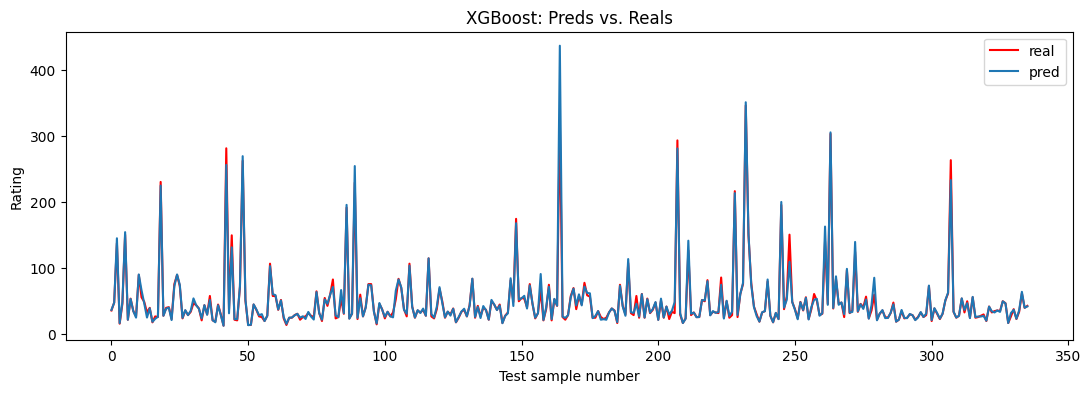

In [28]:
# Make predictions on the test set
y_preds = regressor.predict(X_test)

# Plotting real vs predicted values
plt.figure(figsize=(13, 4))
plt.plot(y_test, label='real', color='r')      # Plotting real values in red
plt.plot(y_preds, label='pred')                # Plotting predicted values

# Adding labels and title
plt.title('XGBoost: Preds vs. Reals')
plt.xlabel('Test sample number')
plt.ylabel('Rating')

# Adding legend to differentiate between real and predicted values
plt.legend()

# Saving the plot as an image file (optional)
# plt.savefig('XGBoost_PredsVsRealsPlot.png', dpi=300)

# Displaying the plot
plt.show()


## Predict


In [29]:
# Example input data
sample_input_1 = [
    0, # Make
    148, # Model
    2013, # Year
    16, # Front Wheel Size (in)
    110,  # SAE Net Horsepower @ RPM
    15,  # Displacement
    1, # Engine Type
    70,  # Width, Max w/o mirrors (in)
    55,  # Height, Overall (in)
    179,  # Length, Overall (in)
    39,  # Gas Mileage
    2, # Drivetrain
    5,  # Passenger Capacity
    4,  # Passenger Doors
    2, # Body Style
]

sample_input_2 = [
    40, # Make
    306, # Model
    2020, # Year
    19, # Front Wheel Size (in)
    250,  # SAE Net Horsepower @ RPM
    20,  # Displacement
    1, # Engine Type
    79,  # Width, Max w/o mirrors (in)
    69,  # Height, Overall (in)
    194,  # Length, Overall (in)
    18,  # Gas Mileage
    1, # Drivetrain
    7,  # Passenger Capacity
    4,  # Passenger Doors
    5, # Body Style
]


In [30]:
msrp_prediction = regressor.predict([sample_input_1])

print(f'Expect MSRP = 28')
print(f'Predict MSRP = {msrp_prediction[0]}')


Expect MSRP = 28
Predict MSRP = 28.04469871520996


In [31]:
msrp_prediction = regressor.predict([sample_input_2])

print(f'Expect MSRP = 50')
print(f'Predict MSRP = {msrp_prediction[0]}')


Expect MSRP = 50
Predict MSRP = 50.3043212890625


## Deploy XGBoost


In [32]:
initial_types = [(
    'float_input',
    FloatTensorType([None, 15]),
)]


In [33]:
onnx_model = onnxmltools.convert_xgboost(regressor, initial_types = initial_types)

onnxmltools.utils.save_model(onnx_model, 'xgboost_ort.onnx')


In [34]:
sess = rt.InferenceSession('xgboost_ort.onnx')


In [35]:
input_name = sess.get_inputs()[0].name
input_name


'float_input'

In [36]:
label_name = sess.get_outputs()[0].name
label_name


'variable'